#### Neural Network Model

We create and train a simple fully connected neural network with one hidden layer of 64 neurons. The output layer uses softmax activation to produce class probabilities. After training (here for 15 epochs), we evaluate training and testing accuracy.

Confusion Matrices: We compute and plot confusion matrices for both the training and test sets.

Membership Inference Attack: We take all softmax outputs (the predicted probability distribution) and extract each sample’s maximum probability (the confidence). Typically, a model tends to have higher confidence on training samples if overfitting occurs. We set a threshold (here, the average training confidence plus a small delta) and infer samples as "members" if their confidence exceeds the threshold. We then print the fraction of training samples inferred as members and test samples inferred as non‑members.

Additional Metric (Optional): As one example of another metric, we compute the negative Euclidean distance between the predicted probability vector and the true one‑hot label. A higher (less negative) value indicates that the predicted distribution is closer to the true one‑hot label.

Epoch 1/15
422/422 - 1s - loss: 0.4435 - accuracy: 0.8804 - val_loss: 0.2023 - val_accuracy: 0.9455 - 1s/epoch - 3ms/step
Epoch 2/15
422/422 - 1s - loss: 0.2178 - accuracy: 0.9380 - val_loss: 0.1619 - val_accuracy: 0.9555 - 579ms/epoch - 1ms/step
Epoch 3/15
422/422 - 1s - loss: 0.1675 - accuracy: 0.9520 - val_loss: 0.1348 - val_accuracy: 0.9623 - 598ms/epoch - 1ms/step
Epoch 4/15
422/422 - 1s - loss: 0.1399 - accuracy: 0.9602 - val_loss: 0.1251 - val_accuracy: 0.9652 - 558ms/epoch - 1ms/step
Epoch 5/15
422/422 - 1s - loss: 0.1193 - accuracy: 0.9652 - val_loss: 0.1152 - val_accuracy: 0.9685 - 559ms/epoch - 1ms/step
Epoch 6/15
422/422 - 1s - loss: 0.1050 - accuracy: 0.9701 - val_loss: 0.1083 - val_accuracy: 0.9708 - 589ms/epoch - 1ms/step
Epoch 7/15
422/422 - 1s - loss: 0.0927 - accuracy: 0.9736 - val_loss: 0.1042 - val_accuracy: 0.9695 - 613ms/epoch - 1ms/step
Epoch 8/15
422/422 - 1s - loss: 0.0826 - accuracy: 0.9764 - val_loss: 0.1015 - val_accuracy: 0.9725 - 602ms/epoch - 1ms/step
Epo

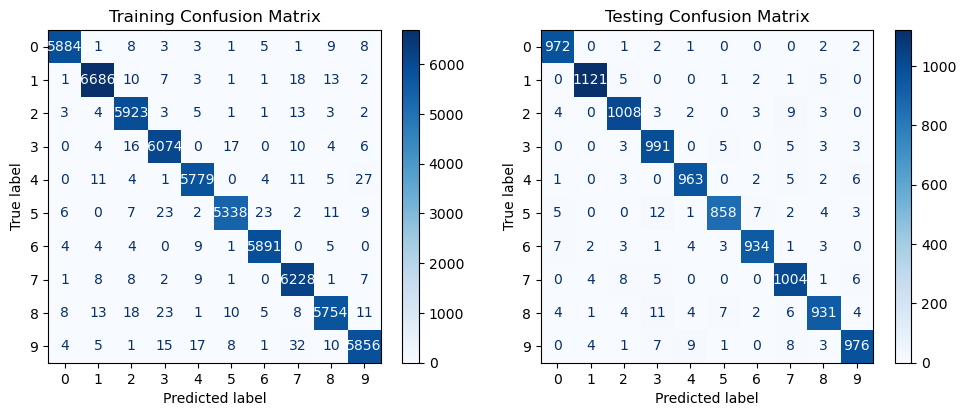

79/79 [==============================] - 0s 1ms/step

Membership Inference Attack based on Softmax Confidence Scores:
Average Maximum Confidence on Training Samples: 0.9800
Average Maximum Confidence on Test Samples:      0.9762
Membership Inference Threshold (max-prob): 1.0000

Membership Inference Decision Outcomes:
Fraction of Training Samples Inferred as Members: 0.00
Fraction of Testing Samples Inferred as Non-Members: 1.00

Additional Membership Inference Metric (Negative Euclidean Distance):
Average on Training samples: -0.0318
Average on Test samples:      -0.0499


In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, hamming

# For reproducibility.
np.random.seed(42)
tf.random.set_seed(42)

#############################################
# 1. Define and Train the Neural Network
#############################################
# Load MNIST data.
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
# Normalize and reshape: images of shape (28,28) -> (784,)
X_train = X_train.astype(np.float32) / 255.0
X_test  = X_test.astype(np.float32) / 255.0

# Build a simple fully connected network with one hidden layer of 64 neurons.
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # 10 output classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model.
history = model.fit(X_train, y_train, epochs=15, batch_size=128,
                    validation_split=0.1, verbose=2)

# Evaluate the model.
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc   = model.evaluate(X_test, y_test, verbose=0)

print("Neural Network Classification Results:")
print("----------------------------------------")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")

#############################################
# 2. Confusion Matrices
#############################################
# Predict labels.
train_preds = np.argmax(model.predict(X_train, batch_size=128), axis=1)
test_preds  = np.argmax(model.predict(X_test, batch_size=128), axis=1)

# Compute confusion matrices.
train_cm = confusion_matrix(y_train, train_preds)
test_cm  = confusion_matrix(y_test, test_preds)

print("\nTraining Confusion Matrix:")
print(train_cm)
print("\nTesting Confusion Matrix:")
print(test_cm)

# Plot confusion matrices.
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=np.arange(10))
disp_train.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Training Confusion Matrix")

plt.subplot(1,2,2)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=np.arange(10))
disp_test.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Testing Confusion Matrix")
plt.tight_layout()
plt.show()

#############################################
# 3. Membership Inference Attack Using Confidence Scores
#############################################
# For each sample (training and test), obtain the softmax output.
prob_train = model.predict(X_train, batch_size=128)
prob_test  = model.predict(X_test, batch_size=128)

# Compute the maximum softmax probability (confidence) for each sample.
conf_train = np.max(prob_train, axis=1)
conf_test  = np.max(prob_test, axis=1)

print("\nMembership Inference Attack based on Softmax Confidence Scores:")
print("Average Maximum Confidence on Training Samples: {:.4f}".format(np.mean(conf_train)))
print("Average Maximum Confidence on Test Samples:      {:.4f}".format(np.mean(conf_test)))

# If the model overfits on the training data, one would expect higher confidence on training samples.
# We now set a simple threshold to decide membership.
# For example, set threshold at (average training confidence + a small delta)
delta = 0.02
threshold = np.mean(conf_train) + delta
print("Membership Inference Threshold (max-prob): {:.4f}".format(threshold))

# Infer membership: if confidence > threshold, label as "member" (True); otherwise, non-member (False).
train_membership = conf_train > threshold
test_membership  = conf_test > threshold

print("\nMembership Inference Decision Outcomes:")
print("Fraction of Training Samples Inferred as Members: {:.2f}".format(np.mean(train_membership)))
# For non-members, we expect test samples to have low confidence:
print("Fraction of Testing Samples Inferred as Non-Members: {:.2f}".format(np.mean(~test_membership)))

#############################################
# Optionally, you can also compute additional metrics.
# For example, Euclidean distance between the softmax vector
# and the corresponding one-hot vector (if the model is well-calibrated,
# training samples might be closer to their true one-hot label).
#############################################
def euclidean_confidence(probs, labels):
    scores = []
    for i in range(len(labels)):
        true_onehot = np.zeros_like(probs[i])
        true_onehot[labels[i]] = 1.0
        # Negative Euclidean distance (so that higher means closer)
        score = -np.linalg.norm(probs[i] - true_onehot)
        scores.append(score)
    return np.array(scores)

euclid_train = euclidean_confidence(prob_train, y_train)
euclid_test  = euclidean_confidence(prob_test, y_test)

print("\nAdditional Membership Inference Metric (Negative Euclidean Distance):")
print("Average on Training samples: {:.4f}".format(np.mean(euclid_train)))
print("Average on Test samples:      {:.4f}".format(np.mean(euclid_test)))

# You could similarly compute a Hamming-based metric if you binarize the probabilities,
# but here we stick with the softmax confidence as the primary metric.


#### Decision Tree

Data Loading and Preprocessing: The MNIST data is loaded, flattened (784 features), and normalized.

Decision Tree Training and Evaluation: We train a decision tree classifier, then compute and print training and testing accuracies along with their confusion matrices.

Membership Inference Using a Fixed Threshold: We obtain predicted probabilities from the tree using predict_proba and extract the maximum probability (confidence) for each sample. By setting a fixed threshold of 0.98 (instead of 0.90), we now expect that samples which are truly “overconfident” (typically training samples or overfitted ones) will have a confidence above 0.98, so those samples will be considered members. In contrast, if test samples are less confident, many will fall below this threshold, giving a higher fraction of test samples inferred as non‑members.

Additional Metric – Negative Euclidean Distance: As an extra experiment, we also compute the negative Euclidean distance between the predicted probability vector and the true one‑hot vector.

Training data shape: (60000, 784), Test data shape: (10000, 784)

Calibrated Decision Tree Model Classification Results:
Training Accuracy: 0.9415
Testing Accuracy:  0.9085

Training Confusion Matrix:
[[5790    4   11   16   12   16   22    4   32   16]
 [   2 6600   28   33    6   28    6   13   17    9]
 [  19   16 5625   41   63   15   22   77   42   38]
 [  10   17   89 5621   23  143   17   83   60   68]
 [   8    9   23   33 5360   27   14   29   65  274]
 [  18   13   21  111   38 5033   46   15   47   79]
 [  28   18   10    9   39   54 5708    8   38    6]
 [   5   21   76   32   27   13    0 5861   18  212]
 [   3   59   54   70   41   38   28   12 5431  115]
 [  16    7   20  132  100   65    7   81   57 5464]]

Testing Confusion Matrix:
[[ 945    1    1    3    1    8   11    3    6    1]
 [   0 1105    4    5    0    5    3    3   10    0]
 [   6    4  936   13   10    6   11   23   18    5]
 [   6    1   19  900    1   41    0   11   22    9]
 [   4    2    5    5  862   

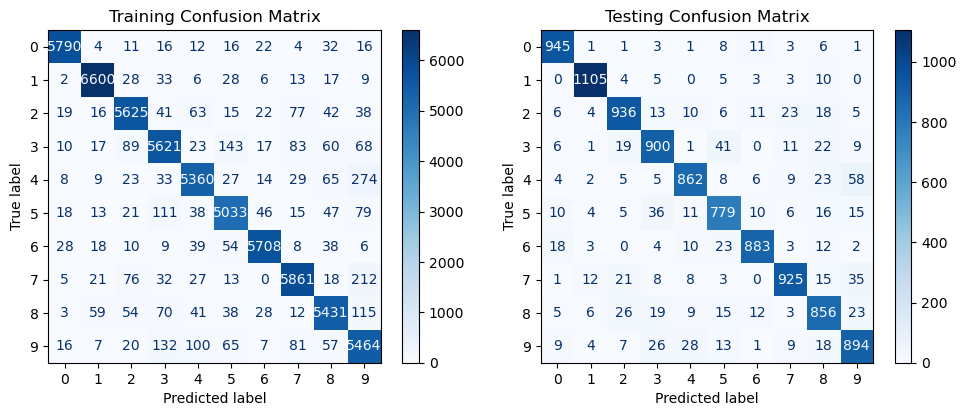

In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#############################################
# 1. Load and Preprocess MNIST Data
#############################################
# Load MNIST from tf.keras.datasets.
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten the images (28x28 -> 784 dimensions) and normalize.
X_train = X_train.reshape(-1, 28*28).astype(np.float32) / 255.0
X_test  = X_test.reshape(-1, 28*28).astype(np.float32) / 255.0

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

#############################################
# 2. Train a Calibrated Decision Tree Classifier
#############################################
# Create a decision tree with maximum depth to avoid overconfident pure leaves.
base_dt = DecisionTreeClassifier(random_state=42, max_depth=10)

# Wrap the decision tree with CalibratedClassifierCV.
# Note: Some versions require using the parameter 'estimator' instead of 'base_estimator'.
calibrated_clf = CalibratedClassifierCV(estimator=base_dt, cv=5, method='sigmoid')
calibrated_clf.fit(X_train, y_train)

# Get predictions.
train_preds = calibrated_clf.predict(X_train)
test_preds  = calibrated_clf.predict(X_test)

# Compute accuracies.
train_acc = accuracy_score(y_train, train_preds)
test_acc  = accuracy_score(y_test, test_preds)

print("\nCalibrated Decision Tree Model Classification Results:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")

#############################################
# 3. Confusion Matrices
#############################################
train_cm = confusion_matrix(y_train, train_preds)
test_cm  = confusion_matrix(y_test, test_preds)

print("\nTraining Confusion Matrix:")
print(train_cm)
print("\nTesting Confusion Matrix:")
print(test_cm)

# Plot confusion matrices.
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=np.arange(10))
disp_train.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Training Confusion Matrix")
plt.subplot(1, 2, 2)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=np.arange(10))
disp_test.plot(cmap="Blues", ax=plt.gca(), values_format="d")
plt.title("Testing Confusion Matrix")
plt.tight_layout()
plt.show()



In [21]:
prob_train = calibrated_clf.predict_proba(X_train)
prob_test  = calibrated_clf.predict_proba(X_test)

# Compute maximum predicted probability (confidence) for each sample.
conf_train = np.max(prob_train, axis=1)
conf_test  = np.max(prob_test, axis=1)

# Dynamically set threshold as the average training confidence + small margin
threshold = np.mean(conf_train) + 0.02

print("\nMembership Inference Attack based on Calibrated Confidence Scores:")
print("Average Maximum Confidence on Training Samples: {:.4f}".format(np.mean(conf_train)))
print("Average Maximum Confidence on Test Samples:      {:.4f}".format(np.mean(conf_test)))
print("Membership Inference Threshold (Dynamic):        {:.4f}".format(threshold))

# Infer membership: assign True for samples with confidence > threshold.
train_membership = conf_train > threshold
test_membership  = conf_test  > threshold

print("\nMembership Inference Decision Outcomes (Dynamic Threshold):")
print("Fraction of Training Samples inferred as members: {:.2f}".format(np.mean(train_membership)))
print("Fraction of Testing Samples inferred as non-members: {:.2f}".format(np.mean(~test_membership)))


Membership Inference Attack based on Calibrated Confidence Scores:
Average Maximum Confidence on Training Samples: 0.7878
Average Maximum Confidence on Test Samples:      0.7717
Membership Inference Threshold (Dynamic):        0.8078

Membership Inference Decision Outcomes (Dynamic Threshold):
Fraction of Training Samples inferred as members: 0.70
Fraction of Testing Samples inferred as non-members: 0.32
